In [13]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.pipeline import Pipeline

In [21]:
try:
    import google.colab
    %pip install numpy pandas matplotlib scikit-learn
except ImportError:
    pass


In [14]:
data_path = 'SAheart.data'

if os.path.exists(data_path):
    os.remove(data_path)
!wget https://hastie.su.domains/ElemStatLearn/datasets/SAheart.data

data = pd.read_csv(data_path)
data = data.drop('row.names', axis=1)
data['famhist'] = data['famhist'].map({'Absent': 0, 'Present': 1})
data = data.sample(frac=1, random_state=2).reset_index(drop=True)

display(data.describe().round(2))
data.info()
data.head()

--2024-10-10 01:12:19--  https://hastie.su.domains/ElemStatLearn/datasets/SAheart.data
Resolving hastie.su.domains (hastie.su.domains)... 159.89.149.97
Connecting to hastie.su.domains (hastie.su.domains)|159.89.149.97|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 25106 (25K)
Saving to: ‘SAheart.data’

SAheart.data        100%[===================>]  24.52K  --.-KB/s    in 0s      

2024-10-10 01:12:19 (261 MB/s) - ‘SAheart.data’ saved [25106/25106]



,sbp,tobacco,ldl,adiposity,famhist,typea,obesity,alcohol,age,chd
count,462.00,462.00,462.00,462.00,462.00,462.00,462.00,462.00,462.00,462.00
mean,138.33,3.64,4.74,25.41,0.42,53.10,26.04,17.04,42.82,0.35
std,20.50,4.59,2.07,7.78,0.49,9.82,4.21,24.48,14.61,0.48
min,101.00,0.00,0.98,6.74,0.00,13.00,14.70,0.00,15.00,0.00
25%,124.00,0.05,3.28,19.77,0.00,47.00,22.98,0.51,31.00,0.00
50%,134.00,2.00,4.34,26.12,0.00,53.00,25.80,7.51,45.00,0.00
75%,148.00,5.50,5.79,31.23,1.00,60.00,28.50,23.89,55.00,1.00
max,218.00,31.20,15.33,42.49,1.00,78.00,46.58,147.19,64.00,1.00


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 462 entries, 0 to 461
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   sbp        462 non-null    int64  
 1   tobacco    462 non-null    float64
 2   ldl        462 non-null    float64
 3   adiposity  462 non-null    float64
 4   famhist    462 non-null    int64  
 5   typea      462 non-null    int64  
 6   obesity    462 non-null    float64
 7   alcohol    462 non-null    float64
 8   age        462 non-null    int64  
 9   chd        462 non-null    int64  
dtypes: float64(5), int64(5)
memory usage: 36.2 KB


,sbp,tobacco,ldl,adiposity,famhist,typea,obesity,alcohol,age,chd
0,124,3.04,4.80,19.52,1,60,21.78,147.19,41,1
1,136,7.36,2.19,28.11,1,61,25.00,61.71,54,0
2,124,0.81,6.16,11.61,0,35,21.47,10.49,26,0
3,108,3.00,1.59,15.23,0,40,20.09,26.64,55,0
4,162,7.00,7.67,34.34,1,33,30.77,0.00,62,0


In [15]:
# Split the data into features and target
X = data.drop('chd', axis=1)
y = data['chd']
features = X.columns
features

Index(['sbp', 'tobacco', 'ldl', 'adiposity', 'famhist', 'typea', 'obesity',
       'alcohol', 'age'],
      dtype='object')

In [16]:
# Split the data into train (80%), validation (10%), and test (10%)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5)

# Standardize the feature
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

X_train, y_train.values

(array([[-0.74786829, -0.76043423, -0.05235128, ..., -0.6800452 ,
         -0.59127806, -1.8218736 ],
        [ 1.09720684,  0.1218762 ,  1.02084992, ...,  1.58056145,
         -0.57827531,  0.77614446],
        [-0.44866692, -0.31396389,  0.2271802 , ..., -0.1686063 ,
         -0.62147801, -0.24938898],
        ...,
        [-0.29906623,  0.08998547,  0.21719693, ...,  0.12331088,
         -0.02419019,  0.50266888],
        [-0.29906623,  0.54708605,  0.87609255, ...,  1.08079923,
         -0.11479003,  0.1608244 ],
        [ 1.09720684, -0.64350152,  1.11069932, ..., -0.10788753,
         -0.64832241,  1.45983342]]),
 array([0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1,
        1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1,
        0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
        1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0,
   

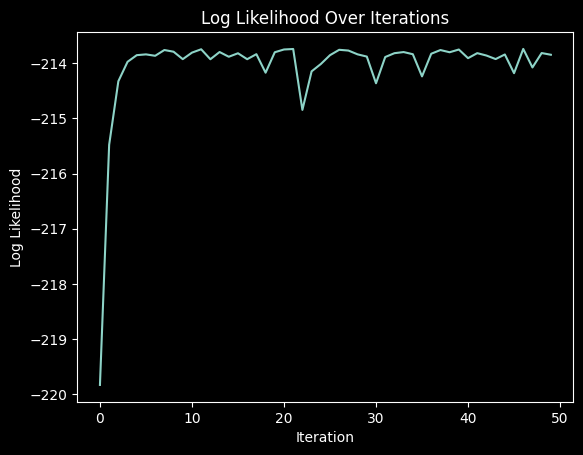

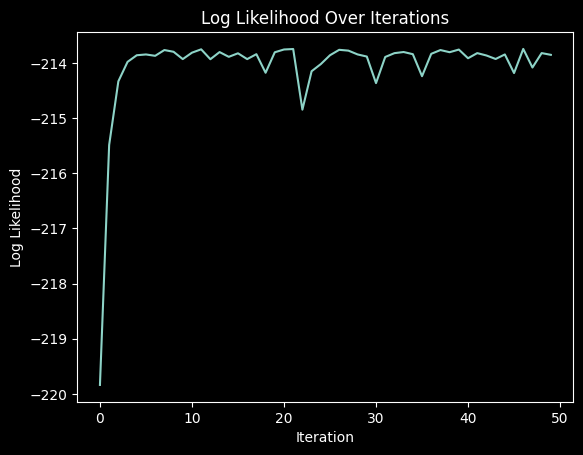

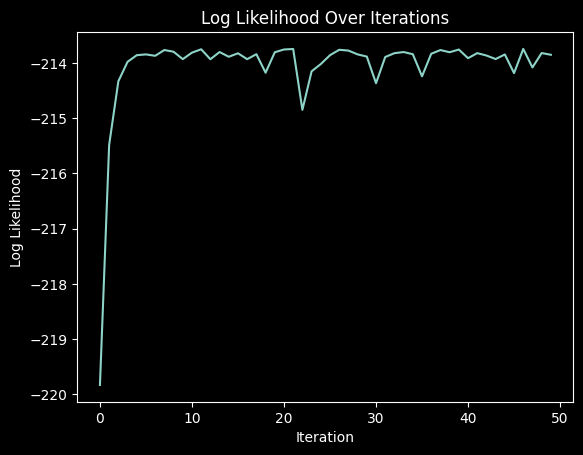

no_reg -213.84885163450124
l1 -213.85035255648353
l2 -213.849136802967


In [17]:
class LogisticRegressionSGD:
    def __init__(self, learning_rate=0.01, C=0.01, num_steps=None, regularization=None, approach='vectorized'):
        self.learning_rate = learning_rate  # Step size for updating weights
        self.C = C  # Regularization strength (L1 or L2 penalty factor)
        self.num_steps = num_steps if num_steps is not None else X.shape[0]  # Number of iterations
        self.regularization = regularization  # Type of regularization: 'l1', 'l2', or None
        self.approach = approach  # Training approach: 'vectorized' or 'stochastic'
        self.weights = None  # Weights will be initialized during training
        self.log_likelihood_values = []  # To store log likelihood values over iterations

    def sigmoid(self, z):
        # S(z) = 1 / (1 + exp(-z))
        return 1 / (1 + np.exp(-z))

    def predict(self, X):
        return self.sigmoid(np.dot(X, self.weights))

    def compute_log_likelihood(self, X, y):
        # log_likelihood = sum(y * log(predictions) + (1 - y) * log(1 - predictions))
        predictions = self.predict(X)
        return np.sum(y * np.log(predictions + 1e-9) + (1 - y) * np.log(1 - predictions + 1e-9)) # 1e-9 is added to prevent log(0)

    def fit(self, X, y):
        # Initialize weights with zeros
        self.weights = np.zeros(X.shape[1])
        
        for step in range(self.num_steps):
            # Shuffle data for stochasticity in each iteration to ensure better convergence
            X, y = shuffle(X, y, random_state=step)
            
            if self.approach == 'vectorized':
                # Vectorized computation for all samples in the dataset
                predictions = self.predict(X)
                errors = y - predictions
                gradient = np.dot(X.T, errors) / X.shape[0]
                
                # Update weights using the gradient and learning rate
                self.weights += self.learning_rate * gradient
            elif self.approach == 'stochastic':
                # Stochastic gradient descent: iterate through each sample
                for i in range(X.shape[0]):
                    prediction = self.predict(X[i])
                    error = y[i] - prediction
                    gradient = X[i] * error
                    
                    # Update weights using the gradient and learning rate
                    self.weights += self.learning_rate * gradient
            
            # Apply Regularization Penalty if regularization is enabled
            if self.regularization == 'l1':
                # L1 Regularization: shrink weights towards zero to encourage sparsity
                self.weights = np.sign(self.weights) * np.maximum(0, np.abs(self.weights) - self.learning_rate * self.C)
            elif self.regularization == 'l2':
                # L2 Regularization: apply penalty proportional to the weight value
                self.weights -= self.learning_rate * self.C * self.weights
            
            log_likelihood = self.compute_log_likelihood(X, y)
            self.log_likelihood_values.append(log_likelihood)

    def plot_log_likelihood(self):
        # Plot the log likelihood values over iterations to visualize convergence
        plt.plot(range(len(self.log_likelihood_values)), self.log_likelihood_values)
        plt.xlabel('Iteration')
        plt.ylabel('Log Likelihood')
        plt.title('Log Likelihood Over Iterations')
        plt.show()

# Example usage
X = X_train
y = y_train.values

learning_rate = 0.01
C = 0.01
num_steps = 50
approach = 'stochastic'

# Train logistic regression using SGD without regularization (vectorized approach)
model_no_reg = LogisticRegressionSGD(learning_rate=learning_rate, C=C, num_steps=num_steps, regularization=None, approach=approach)
model_no_reg.fit(X_train, y_train.values)
model_no_reg.plot_log_likelihood()

# Train logistic regression using SGD with L1 regularization (stochastic approach)
model_l1 = LogisticRegressionSGD(learning_rate=learning_rate, C=C, num_steps=num_steps, regularization='l1', approach=approach)
model_l1.fit(X_train, y_train.values)
# model_l1.plot_log_likelihood()

# Train logistic regression using SGD with L2 regularization (vectorized approach)
model_l2 = LogisticRegressionSGD(learning_rate=learning_rate, C=C, num_steps=num_steps, regularization='l2', approach=approach)
model_l2.fit(X_train, y_train.values)
# model_l2.plot_log_likelihood()

print("no_reg", model_no_reg.log_likelihood_values[-1])
print("l1", model_l1.log_likelihood_values[-1])
print("l2", model_l2.log_likelihood_values[-1])

In [18]:
# Manual Forward Stepwise Feature Selection using Cross-Validation with LogisticRegressionSGD
best_score = -np.inf
selected_features = []
available_features = list(features)

while available_features:
    best_feature = None
    for feature in available_features:
        current_features = selected_features + [feature]
        X_train_subset = pd.DataFrame(X_train, columns=features)[current_features].values
        X_val_subset = pd.DataFrame(X_val, columns=features)[current_features].values
        model = LogisticRegressionSGD(learning_rate=0.01, C=0.01, num_steps=100, regularization=None, approach='stochastic')
        
        model.fit(X_train_subset, y_train.values)
        predictions = model.predict(X_val_subset) >= 0.5
        score = accuracy_score(y_val, predictions)
        
        if score > best_score:
            best_score = score
            best_feature = feature
    
    if best_feature is not None:
        selected_features.append(best_feature)
        available_features.remove(best_feature)
    else:
        break

print("Selected Features: ", selected_features)

Selected Features:  ['sbp', 'obesity', 'ldl']
